In [1]:
!pip install pandas scikit-learn matplotlib lightgbm --quiet

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

from ipaddress import ip_address
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


In [3]:
print("Upload do arquivo 'train_test_network.csv")
df = pd.read_csv('train_test_network.csv')

Upload do arquivo 'train_test_network.csv


In [5]:
def is_internal_ip(ip_str):
    if not isinstance(ip_str, str):
        return False
    try:
        return ip_address(ip_str).is_private
    except ValueError:
        return False
df['src_is_internal'] = df['src_ip'].apply(is_internal_ip).astype(int)
df['dst_is_internal'] = df['dst_ip'].apply(is_internal_ip).astype(int)

In [8]:
try:
    X = df.drop(columns=['label', 'type', 'src_ip', 'dst_ip'])
    y = df['label'].astype(int)
except KeyError as e:
    print(f"Erro ao definir X e y: Coluna não encontrada - {e}")
    raise

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=None, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=None, stratify=y_temp
)

print("Dados divididos em Treino e Teste")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_val:   {X_val.shape}")
print(f"Formato de X_test: {X_test.shape}\n")

print("Verificando os índices dos dados de treino") #verificando se o random state none esta funcionando
print(X_train.index[:5])

--- Dados divididos em Treino e Teste ---
Formato de X_train: (126625, 42)
Formato de X_val:   (42209, 42)
Formato de X_test: (42209, 42)

--- Verificando os índices dos dados de treino ---
Index([189376, 70706, 73632, 129402, 156382], dtype='int64')


In [ ]:
# One-Hot Encoding para colunas categóricas
print("Convertendo colunas 'string' para formato numérico")
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True, dtype=int)
X_val = pd.get_dummies(X_val, columns=categorical_columns, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True, dtype=int)

print("Alinhando colunas entre os conjuntos de treino e teste")
all_cols = X_train.columns.union(X_val.columns).union(X_test.columns)

X_train = X_train.reindex(columns=all_cols, fill_value=0)
X_val = X_val.reindex(columns=all_cols, fill_value=0)
X_test = X_test.reindex(columns=all_cols, fill_value=0)



# Imputação de valores ausentes
print("Preenchendo valores ausentes com a média do treino")
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=all_cols)
X_val = pd.DataFrame(imputer.transform(X_val), columns=all_cols) 
X_test = pd.DataFrame(imputer.transform(X_test), columns=all_cols) 



# Normalização (Scaling)
print("Normalizando características com base nos dados de treino")
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=all_cols)
X_val = pd.DataFrame(scaler.transform(X_val), columns=all_cols) 
X_test = pd.DataFrame(scaler.transform(X_test), columns=all_cols) 


# Remoção de caracteres especiais dos nomes das colunas
print("Removendo caracteres especiais dos nomes das colunas\n")
X_train.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns]
X_val.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_val.columns]
X_test.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns]

print("Pré-processamento concluído com sucesso!")

Convertendo colunas 'string' para formato numérico...
Alinhando colunas entre os conjuntos de treino e teste...
Preenchendo valores ausentes com a média do treino...
Normalizando características com base nos dados de treino...
Removendo caracteres especiais dos nomes das colunas...

--- Pré-processamento concluído com sucesso! ---


Treinamento LightGbm

In [12]:
lgbm_selector = LGBMClassifier(random_state=None)
lgbm_selector.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 96625, number of negative: 30000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 126625, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763080 -> initscore=1.169640
[LightGBM] [Info] Start training from score 1.169640


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Analise da importancia das caracteristicas LightGbm

In [13]:
importances = lgbm_selector.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15
top_features_list = X_train.columns[indices[:top_n]].tolist()

print(f"\nAs {top_n} características mais importantes selecionadas a partir do treino são:")
print(top_features_list)
X_train_reduzido = X_train[top_features_list]
X_test_reduzido = X_test[top_features_list]
print(f"\nFormato do dataset de treino reduzido: {X_train_reduzido.shape}")
print(f"Formato do dataset de teste reduzido: {X_test_reduzido.shape}\n")


As 15 características mais importantes selecionadas a partir do treino são:
['src_port', 'src_ip_bytes', 'dst_port', 'duration', 'src_pkts', 'src_bytes', 'dst_ip_bytes', 'dst_is_internal', 'dst_pkts', 'dst_bytes', 'proto_tcp', 'conn_state_REJ', 'http_status_code', 'dns_RA_T', 'dns_qtype']

Formato do dataset de treino reduzido: (126625, 15)
Formato do dataset de teste reduzido: (42209, 15)



Criaçao de um dataframe com caracteristicas reduzidas LightGBM

In [45]:
X_reduzido = X_train[top_features_list]
X_test_reduzido = X_test[top_features_list]

print("Novo DataFrame 'X_train_reduzido' criado com as seguintes colunas:")
print(X_train_reduzido.columns.tolist())
print(f"Formato do novo dataset de treino: {X_train_reduzido.shape}\n")

print("Novo DataFrame 'X_test_reduzido' criado com as seguintes colunas:")
print(X_test_reduzido.columns.tolist())
print(f"Formato do novo dataset de teste: {X_test_reduzido.shape}")

Novo DataFrame 'X_train_reduzido' criado com as seguintes colunas:
['src_port', 'dst_port', 'duration', 'src_ip_bytes', 'dst_ip_bytes', 'src_pkts', 'src_bytes', 'dst_bytes', 'proto_tcp', 'dst_pkts', 'http_status_code', 'conn_state_REJ', 'dns_qtype', 'proto_udp', 'service_dns']
Formato do novo dataset de treino: (126625, 15)

Novo DataFrame 'X_test_reduzido' criado com as seguintes colunas:
['src_port', 'dst_port', 'duration', 'src_ip_bytes', 'dst_ip_bytes', 'src_pkts', 'src_bytes', 'dst_bytes', 'proto_tcp', 'dst_pkts', 'http_status_code', 'conn_state_REJ', 'dns_qtype', 'proto_udp', 'service_dns']
Formato do novo dataset de teste: (42209, 15)


treinamento

In [46]:
try:
    y = df['label']
except KeyError:
    print("Erro: A coluna 'label' não foi encontrada no DataFrame.")
    print("Por favor, verifique o nome da sua coluna de classificação (ex: 'attack', 'class') e altere o código.")
    raise


--- Avaliação do Modelo ---
Acurácia do modelo: 0.9993

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209

Matriz de Confusão:


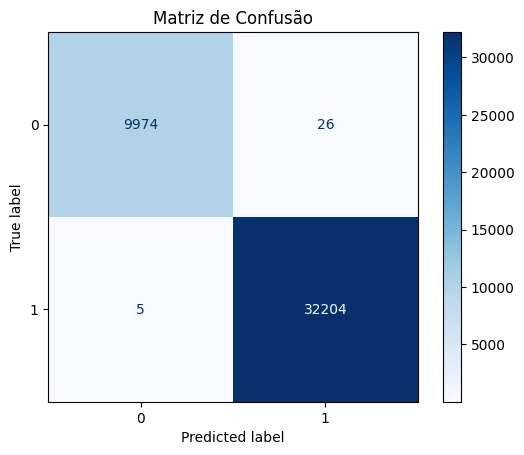

In [ ]:
print("\n Avaliação do Modelo")

# Fazendo previsões nos dados de teste
y_pred = lgbm_selector.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}")

# Exibindo o Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Gerando e exibindo a Matriz de Confusão
print("Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

--- Treinando o modelo final LightGBM apenas com as melhores features ---
[LightGBM] [Info] Number of positive: 96625, number of negative: 30000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2033
[LightGBM] [Info] Number of data points in the train set: 126625, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763080 -> initscore=1.169640
[LightGBM] [Info] Start training from score 1.169640
--- Treinamento concluído! ---

--- Avaliação do Modelo Final Reduzido no Conjunto de TESTE ---
Acurácia Final do Modelo Reduzido: 0.9985

Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                    

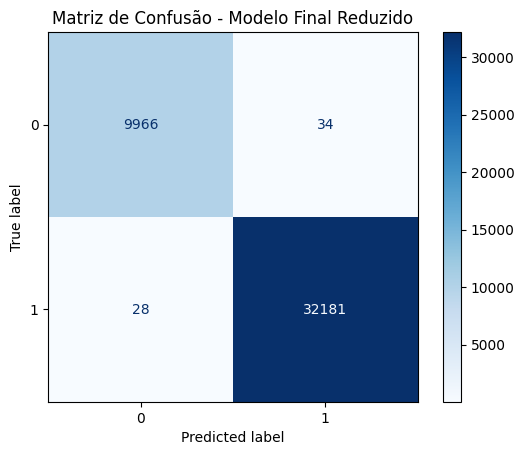

In [ ]:
#Treinamento e Avaliação do Modelo Final com caracteristicas Reduzidas

X_val_reduzido = X_val[top_features_list]

print("Treinando o modelo final LightGBM apenas com as melhores caracteristicaa")
# Instancia um novo modelo final
lgbm_final_model = LGBMClassifier(random_state=42)

lgbm_final_model.fit(
    X_train_reduzido, y_train,
    eval_set=[(X_val_reduzido, y_val)],

)
print(" Treinamento concluído! \n")


# Avaliação Final no Conjunto de TESTE Reduzido 
print(" Avaliação do Modelo Final Reduzido no Conjunto de TESTE ")
y_pred_final = lgbm_final_model.predict(X_test_reduzido)
accuracy_final = accuracy_score(y_test, y_pred_final)

print(f"Acurácia Final do Modelo Reduzido: {accuracy_final:.4f}\n")
print("Relatório de Classificação Final:")
print(classification_report(y_test, y_pred_final))

# Matriz de Confusão
cm_final = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Modelo Final Reduzido")
plt.show()